**Chapter 8 – Dimensionality Reduction**

_This notebook contains all the sample code and solutions to the exercises in chapter 8._

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## The Curse of Dimensionality 
  
- Many machine learning problems involve thousands or even millions of features for each training instance. 
- Not only do all these features make **training extremely slow**, but they can also make it much **harder to find a good solution**.
- This problem is often referred to as the **curse of dimensionality**. 
- Fortunately, in real-world problems, it is **often possible to reduce the number of features considerably**, turning an intractable problem into a tractable one. 
- Example: MNIST images (introduced in Chapter 3): 
  - pixels on the image borders are almost always white, so you could completely drop these pixels from the training set without losing much information. 
  - As we saw in the previous chapter: these pixels are utterly unimportant for the classification task.  
  
    ![](img/mnist_pixel_importance.png)  
 
  - Additionally, two neighboring pixels are often highly correlated: if you merge them into a single pixel (e.g., by taking the mean of the two pixel intensities), you will not lose much information.

## Main Approaches for Dimensionality Reduction

### Projection
  
- In most real-world problems, training instances are not spread out uniformly across all dimensions. 
- Many features are almost constant, while others are highly correlated (as discussed earlier for MNIST). 
- As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 
- Example: 3D dataset represented by small red spheres.

![](img/dimred1.png)

- Notice that all training instances lie close to a plane: this is a lower-dimensional (2D) subspace of the higher-dimensional (3D) space. 
- If we project every training instance perpendicularly onto this subspace, we get the new 2D dataset (blue spheres in the above diagram):

![](img/dimred2.png)

$z_1$ and $z_2$ are the axes corresponding to the new features. 

### Manifold learning  

- Projection is not always the best approach to dimensionality reduction. 
- In many cases the subspace may twist and turn, such as in the famous Swiss roll toy dataset represented in the figure below.

![](img/swiss_roll.jpg)

![](img/swiss_roll_plot.png)

Simply projecting onto a plane (e.g., by dropping x3) would squash different layers of the Swiss roll together (left image):
![](img/squished_swiss_roll_plot.png)

What you probably want instead is to unroll the Swiss roll to obtain the 2D dataset on the right side of the figure above. 

- The Swiss roll is an example of a __2D manifold__. 
- A 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space.

- Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie: __manifold learning__. 
- It relies on the manifold assumption: most real-world high-dimensional datasets lie close to a much lower-dimensional - manifold. This assumption is very often empirically observed.

Let's now consider both techniques in practice, starting with projection. 

# PCA

- Principal component analysis (PCA) is by far the most popular dimensionality reduction algorithm. 
- First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like in the figures above.

## Preserving the variance

- Project = choosing the right hyperplane. 
- Example a simple 2D dataset (red dots) is represented on the left, along with three different axes (i.e., 1D hyperplanes).
- On the right is the result of the projection of the dataset onto each of these axes.
![](img/pca_best_projection_plot.png)
- The projection onto the solid line preserves the maximum variance (top)
- The projection onto the dotted line preserves very little variance (bottom)
- The projection onto the dashed line preserves an intermediate amount of variance (middle).
PCA

- It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. 
- Another way to justify this choice is that it is **the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis**. 
- This is the rather simple idea behind PCA.

## Principal Components

- PCA identifies the axis that accounts for the largest amount of variance in the training set.
- It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of the remaining variance.
- The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data.
- In the figure ahove
  - the first PC is the axis on which vector **$c_1$** lies
  - the second PC is the axis on which vector **$c_2$** lies
  
>- For each principal component, PCA finds a **zero-centered** unit vector pointing in the direction of the PC. 
>- Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned by PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. 
>- However, they will generally still lie on the same axes. 
>- In some cases, a pair of unit vectors may even rotate or swap (if the variances along these two axes are very close), but the plane they define will generally remain the same.
  
- The underlying mathematical technique used for finding the PC's is **singular value decomposition** (SVD) (see course "Mathematics for Machine Learning"). 

## Projecting Down to d Dimensions

- Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components.
- Selecting this hyperplane ensures that the **projection will preserve as much variance as possible**.

## Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA

# Generate a small 3D dataset. 
# It's an oval shape, rotated in 3D space, with points distributed unevenly, and with quite a lot of noise:
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

pca = PCA(n_components=2) # reduce 3D dataset to 2D
X2D = pca.fit_transform(X)

In [5]:
print(X)

[[-0.47562927 -1.18002627 -0.18665138]
 [-0.32908278  0.18101846 -0.32767249]
 [ 1.1241412   0.33792292  0.15481443]
 [ 0.28072425 -0.21472162  0.43963185]
 [-0.59903727 -0.94120105  0.06412454]
 [-0.19688428 -0.59920621  0.01191996]
 [-0.49635908 -1.18078845  0.17385141]
 [ 0.57308241  0.89868775  0.66600244]
 [ 0.59410487 -0.55817151  0.2549555 ]
 [ 1.17064931  0.37224377  0.80362823]
 [-1.1730746  -1.04622548 -0.08061077]
 [-0.60011541 -0.3620432  -0.50511579]
 [ 0.4963413   0.74149446  0.76848193]
 [-0.39977922 -0.95243354 -0.15466053]
 [-0.35448133 -0.44161974 -0.07728984]
 [-0.42846627 -0.63087978  0.31216388]
 [-0.48357266 -0.92949165 -0.12834249]
 [-0.30000318 -0.94201494  0.07449738]
 [-0.14919128 -0.76135868 -0.35919894]
 [-0.42432217 -0.85484973 -0.22736351]
 [ 0.29610766 -0.47325168  0.67240606]
 [-0.50528609 -0.61262398  0.0100251 ]
 [-0.80287158 -1.12187728 -0.06244262]
 [ 0.15477346 -0.34038017  0.22750726]
 [ 0.01693824 -1.05829041  0.33967741]
 [ 0.94308215  0.99735859

In [6]:
pca.components_  # one row per principal component, one column per original feature

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

In [6]:
print(X2D)

[[-8.73231190e-01  2.94598030e-01]
 [ 1.48885182e-01 -5.14935573e-01]
 [ 1.35121872e+00  3.99501548e-01]
 [ 4.54366763e-01  1.39984497e-01]
 [-7.34389086e-01  2.28934648e-02]
 [-2.33347464e-01  8.67844755e-02]
 [-8.08435321e-01  2.52457557e-01]
 [ 1.48281454e+00 -4.22796305e-01]
 [ 3.85679006e-01  6.16229365e-01]
 [ 1.54972180e+00  3.60381563e-01]
 [-1.22938760e+00 -3.12504780e-01]
 [-4.54653275e-01 -3.28839370e-01]
 [ 1.34315899e+00 -3.79446240e-01]
 [-6.55233341e-01  1.92367174e-01]
 [-2.49510114e-01 -1.28486810e-01]
 [-3.46562831e-01 -8.32312189e-02]
 [-6.90221113e-01  1.13712645e-01]
 [-5.29757591e-01  2.40403321e-01]
 [-3.96344855e-01  2.60334107e-01]
 [-6.19519220e-01  1.13588889e-01]
 [ 3.34910399e-01  3.09476565e-01]
 [-4.52441114e-01 -1.28501562e-01]
 [-1.02718730e+00  7.20555799e-03]
 [ 2.34128174e-01  1.50077825e-01]
 [-3.37764152e-01  5.30112382e-01]
 [ 1.69474397e+00 -1.82984269e-01]
 [-1.09314174e-01  3.51175914e-01]
 [ 4.35623436e-01  6.12839802e-01]
 [ 2.35325731e-01  5

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [7]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

- The ratio indicates the proportion of the dataset’s variance that lies along each principal component.
- The first dimension explains about 76% of the variance, while the second explains about 15%.
- So by projecting down to 2D, we lost about 9% of the variance:

In [8]:
1 - pca.explained_variance_ratio_.sum()  # extra code

0.09028309326742046

## Choosing the Right Number of Dimensions

- Above we have arbitrarily chosen the number of dimensions to reduce down to 
- It is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95% 
- An exception to this rule, of course, is if you are reducing dimensionality for data visualization, in which case you will want to reduce
the dimensionality down to 2 or 3.
- The following code loads and splits the MNIST dataset (introduced in Chapter 3) and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA() # no n_components specified, so PCA will keep all components
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print()
cumsum = np.cumsum(pca.explained_variance_ratio_)
print(cumsum)
print()
print(cumsum >= 0.95)
# np.argmax returns the first index of the maximum value in the array
d = np.argmax(cumsum >= 0.95) + 1  # d equals 154

[9.70466436e-02 7.09592406e-02 6.16908876e-02 5.38941949e-02
 4.86879702e-02 4.31223132e-02 3.27192995e-02 2.88389545e-02
 2.76202940e-02 2.35700055e-02 2.10918962e-02 2.02299108e-02
 1.71581820e-02 1.69211143e-02 1.57864128e-02 1.48295261e-02
 1.32456095e-02 1.27689737e-02 1.18726294e-02 1.15268370e-02
 1.06616621e-02 1.00671337e-02 9.53573327e-03 9.12543746e-03
 8.83404692e-03 8.39319141e-03 8.12578809e-03 7.86366084e-03
 7.44733102e-03 6.90859128e-03 6.58093773e-03 6.48147870e-03
 6.02615030e-03 5.86582188e-03 5.70021474e-03 5.43627771e-03
 5.05786416e-03 4.87858604e-03 4.81429342e-03 4.72266326e-03
 4.56746921e-03 4.44836012e-03 4.18501329e-03 3.98215339e-03
 3.84974607e-03 3.75103387e-03 3.62008852e-03 3.51591277e-03
 3.40058205e-03 3.21874467e-03 3.19017051e-03 3.12804939e-03
 2.95982668e-03 2.88954600e-03 2.84130398e-03 2.71435811e-03
 2.69521453e-03 2.58472546e-03 2.53770594e-03 2.44780960e-03
 2.40506133e-03 2.39262901e-03 2.30408489e-03 2.21532131e-03
 2.13720816e-03 2.072252

In [13]:
d

154

- You could then set _n_components=d_ and run PCA again, but there’s a better option.
- Instead of specifying the number of principal components you want to preserve, you can set _n_components_ to be a float between $0.0$ and $1.0$, indicating the ratio of variance you wish to preserve:

In [14]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

The actual number of components is determined during training, and it is stored in the _n_components__ attribute:

In [15]:
pca.n_components_

154

In [16]:
pca.explained_variance_ratio_.sum()  

0.9501960192613035

- Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot cumsum). 
- There will usually be an elbow in the curve, where the explained variance stops growing fast. 
- In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn’t lose too much
explained variance.

![](img/explained_variance_plot.png)

- Lastly, if you are using dimensionality reduction as a preprocessing step for a supervised learning task (e.g., classification), then you can tune the number of dimensions as you would any other hyperparameter. 
- For example, the following code example creates a two-step pipeline, first reducing dimensionality using PCA, then classifying using a random forest. 
- Next, it uses RandomizedSearchCV to find a good combination of hyperparameters for both PCA and the random forest classifier.
- This example does a quick search, tuning only 2 hyperparameters, training on just 1,000 instances of MNIST, and running for just 10 iterations. 
- We use RandomizdSearchCV iso GridSearchCV because in this case it's much faster. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [18]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


## PCA for Compression

- After dimensionality reduction, the training set takes up much less space. 
- For example, after applying PCA to the MNIST dataset while preserving 95% of its variance,we are left with 154 features, instead of the original 784 features. 
- So the dataset is now less than 20% of its original size, and we only lost 5% of its variance! 
- This is a reasonable compression ratio, and it’s easy to see how such a size reduction would speed up a classification algorithm tremendously.
- It is also possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection. 
- This won’t give you back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. 

In [21]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [22]:
X_recovered = pca.inverse_transform(X_reduced)

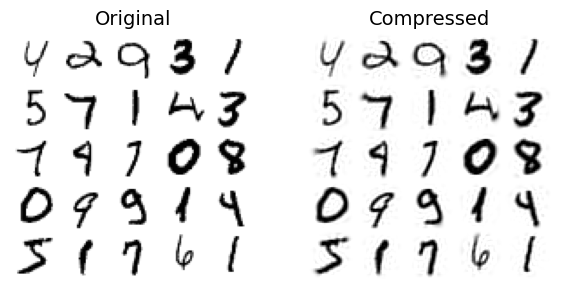

In [23]:
# extra code to plot the recovered digits

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

# LLE

_Locally linear embedding_ (LLE) is a nonlinear dimensionality reduction (NLDR) technique.
- It is a **manifold learning** technique that does not rely on projections, unlike PCA
- In a nutshell, LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a
low-dimensional representation of the training set where these local relationships are best preserved. 
- This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.
- The following code makes a Swiss roll, then uses `Scikit-Learn`’s `LocallyLinearEmbedding` class to unroll it:

In [26]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss,t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

- The variable t is a 1D NumPy array containing the position of each instance along
the rolled axis of the Swiss roll. 
- We don’t use it in this example, but it can be used as a
target for a nonlinear regression task.
- The resulting 2D dataset looks as below. 
- As you can see, the Swiss roll is completely unrolled, and the distances between instances are locally well preserved.
  ![](img/lle_unrolling_plot.png)

In [27]:
t

array([ 8.24234644, 13.67266022, 11.61126935, 10.35461227,  6.18283002,
        6.1826027 ,  5.25981413, 12.87590683, 10.37776449, 11.38581581,
        4.90639327, 13.85357398, 12.55797604,  6.71363795,  6.42604892,
        6.44093576,  7.57980457,  9.65810183,  8.78337487,  7.45715896,
       10.47896666,  6.02708764,  7.46578743,  8.16526801,  9.01074732,
       12.11249808,  6.59427004,  9.55893438, 10.29576475,  5.15017381,
       10.43836431,  6.31954098,  5.3254858 , 13.65542448, 13.81325648,
       12.33135449,  7.58330612,  5.63292697, 11.16113333,  8.8607285 ,
        5.86257225,  9.37932141,  5.03649316, 13.28253187,  7.15133285,
       10.9565144 ,  7.65019666,  9.6139146 ,  9.86501197,  6.45460118,
       13.85050881, 12.01784373, 13.5669579 , 13.14593807, 10.34746352,
       13.40084895,  5.54641116,  6.55948394,  5.13864614,  7.77855511,
        8.37558613,  7.26979335, 12.52305599,  8.07470987,  7.36013436,
        9.82717906,  6.04056851, 12.2729174 ,  5.41501224, 14.01

- However, distances are not preserved on a larger scale: the unrolled Swiss roll shouldbe a rectangle, not this kind of stretched and twisted band. 
- Nevertheless, LLE did a pretty good job of modeling the manifold.

## t-SNE

- t-distributed stochastic neighbor embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. 
- t-SNE will maximize the distance in two-dimensional space between observations that are most different in a high-dimensional space. 
- Because of this, observations that are similar will be close to one another and may become clustered.
- It is mostly used for visualization, in particular to visualize clusters of instances in highdimensional
space. 
- As an example, we will use t-SNE to visualize a 2D map of the MNIST images.

- We use t-SNE to reduce the first 5,000 images of the MNIST dataset down to two dimensions and plot the result using Matplotlib. 
- You can use a scatterplot using 10 different colors to represent each image's target class.

Let's limit ourselves to the first 5,000 images of the MNIST training set, to speed things up a lot.

In [29]:
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]

X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

X_sample, y_sample = X_train[:5000], y_train[:5000]

Let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [30]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
%time X_reduced = tsne.fit_transform(X_sample)

CPU times: total: 1min 41s
Wall time: 13.1 s


Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

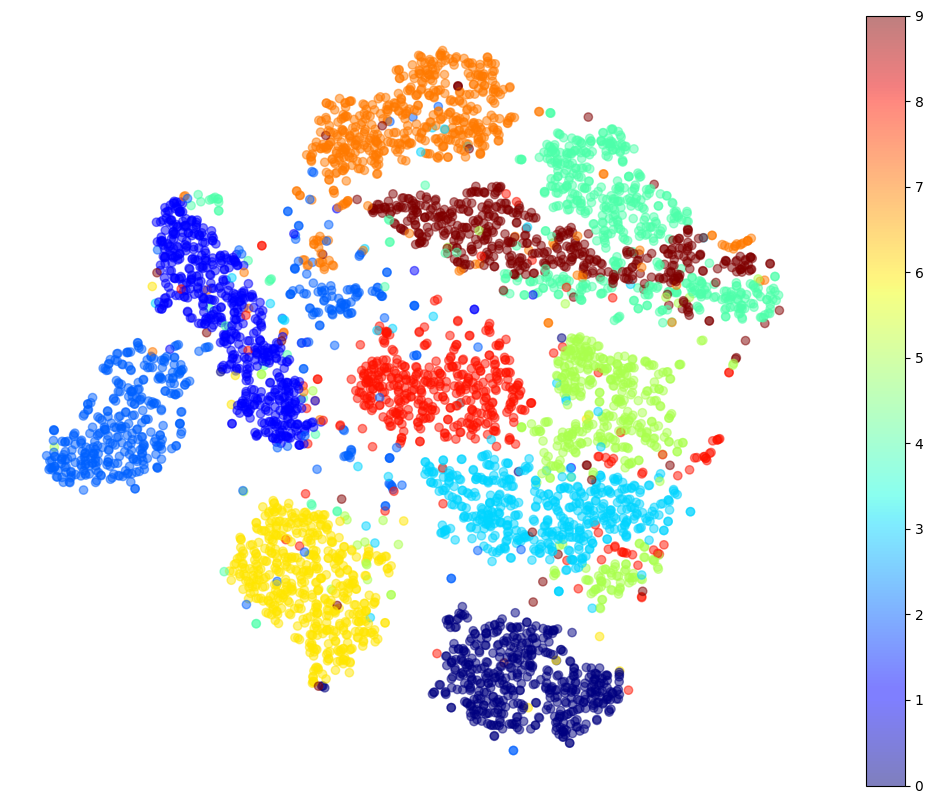

In [31]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],
            c=y_sample.astype(np.int8), cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

- Isn't this just beautiful?
- Most digits are nicely separated from the others, even though t-SNE wasn't given the targets: it just identified clusters of similar images. 
- But there is still a bit of overlap. 
- For example, the 3s and the 5s overlap a lot (on the right side of the plot), and so do the 4s and the 9s (in the top-right corner).

Let's focus on just the digits 4 and 9:

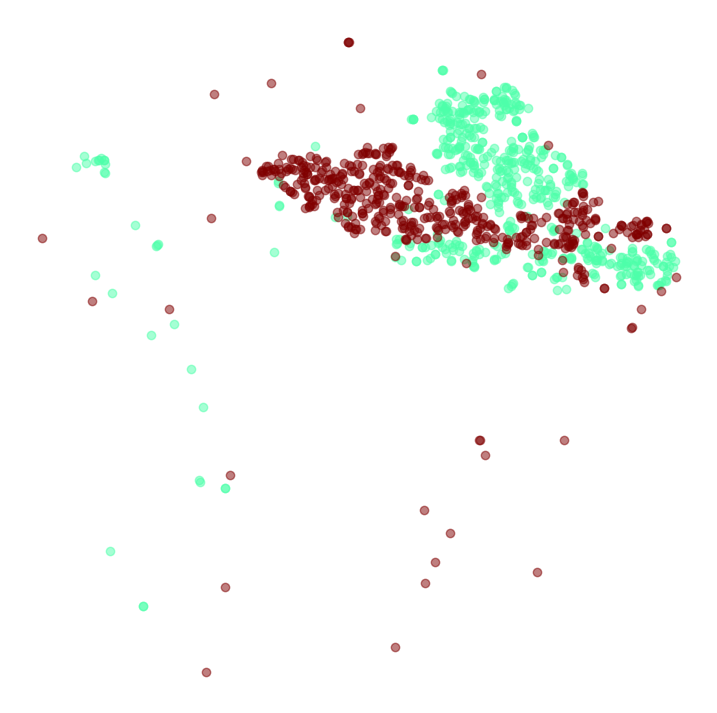

In [32]:
plt.figure(figsize=(9, 9))
cmap = plt.cm.jet
for digit in ('4', '9'):
    plt.scatter(X_reduced[y_sample == digit, 0], X_reduced[y_sample == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on just these 2 digits:

In [33]:
idx = (y_sample == '4') | (y_sample == '9')
print(idx)
X_subset = X_sample[idx]
y_subset = y_sample[idx]

tsne_subset = TSNE(n_components=2, init="random", learning_rate="auto",
                   random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

[False False  True ... False False False]


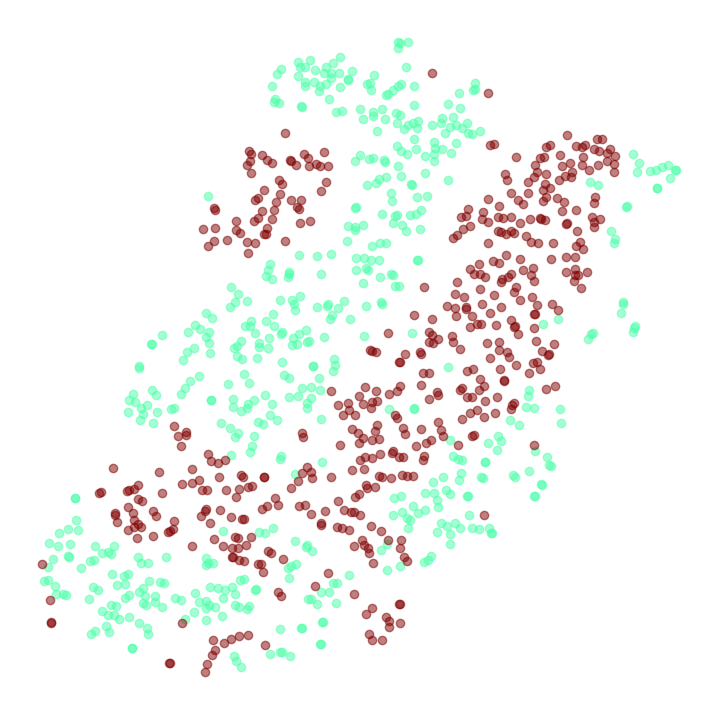

In [36]:
plt.figure(figsize=(9, 9))
for digit in ('4', '9'):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c=[cmap(float(digit) / 9)], alpha=0.5)
plt.axis('off')
plt.show()

- That's much better, although there's still a bit of overlap. 
- Perhaps some 4s really do look like 9s, and vice versa. 